# Tracer Advection Stencil

#### 1. Start a parallel cluster

In [2]:
from functions import show_clusters

import ipyparallel as ipp

cluster = ipp.Cluster(engines='mpi', n=6).start_and_connect_sync()


Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

In [3]:
show_clusters()

cluster_id        state    cluster_file
1657903669-p0fh  running   /home/ajdas/.ipython/profile_default/security/cluster-1657903669-p0fh.json
1657903328-mh0p  running   /home/ajdas/.ipython/profile_default/security/cluster-1657903328-mh0p.json


In [4]:
%autopx

%autopx enabled


#### 2. Configure the domain

In [440]:
%%capture
from mpi4py import MPI
import functions as func
import importlib
importlib.reload(func)


mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

backend = 'numpy'
layout = (1, 1)
nx, ny, nz, nhalo = 100, 100, 79, 3
dimensions = {'nx': nx, 'ny': ny, 'nx1': nx+1, 'ny1': ny+1, 'nz': nz, 'nhalo': nhalo, 'tile': mpi_size, 'nxhalo': nx+2*nhalo, 'nyhalo': ny+2*nhalo}
units = {'dist': 'm', 'coord': 'degrees', 'qvapor': 'kg/kg', 'psi': 'kg/m/s', 'wind': 'm/s', 'courant': '', 'areaflux': 'm2', 'qflux': 'kg/m2', 'pressure': 'Pa'}
origins = {'halo': (0, 0), 'compute_2d': (dimensions['nhalo'], dimensions['nhalo']), 'compute_3d': (dimensions['nhalo'], dimensions['nhalo'], 0)}


configuration = func.configure_domain(layout, mpi_comm, dimensions, backend=backend)

#### 2a. Gather domain coordinates

In [441]:
from pace.util import Quantity
import numpy as np

dx_halo =  Quantity(configuration['grid_data'].dx.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dy_halo =  Quantity(configuration['grid_data'].dy.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dxa_halo =  Quantity(configuration['grid_data'].dxa.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dya_halo =  Quantity(configuration['grid_data'].dya.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dxc_halo =  Quantity(configuration['grid_data'].dxc.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dyc_halo =  Quantity(configuration['grid_data'].dyc.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)

lona_halo =  Quantity(configuration['grid_data'].lon_agrid.data * 180 / np.pi, ('x_halo', 'y_halo'), units['coord'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
lata_halo =  Quantity(configuration['grid_data'].lat_agrid.data * 180 / np.pi, ('x_halo', 'y_halo'), units['coord'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
lona_global = configuration['communicator'].gather(lona_halo)
lata_global = configuration['communicator'].gather(lata_halo)

#### 3. Create initial conditions on a plane

#### 3a. Create water vapor initial condition

In [442]:
if mpi_rank == 0:
    gaussian_multiplier = func.create_gaussianMultiplier(np.deg2rad(lona_global.data), np.deg2rad(lata_global.data), dimensions, center_tile=0)
else:
    gaussian_multiplier = np.zeros((dimensions['tile'], dimensions['nxhalo'], dimensions['nyhalo']))

mpi_comm.Bcast(gaussian_multiplier, root=0)
qvapor_2d = Quantity(gaussian_multiplier[mpi_rank], ('x', 'y'), units['qvapor'], origins['compute_2d'], (dimensions['nx'], dimensions['ny']), backend)


[stdout:0] Centering gaussian on lon=351.01, lat=1.01


#### 3b. Create pressure thickness initial condition

In [443]:
delp_2d = Quantity(np.ones(qvapor_2d.data.shape)*10, ('x', 'y'), units['pressure'], origins['compute_2d'], (dimensions['nx'], dimensions['ny']), backend)

#### 3c. Run coordinates through streamfunction generation

In [444]:
psi, psi_staggered = func.calculate_streamfunction_testCase1(np.deg2rad(lona_halo.data), np.deg2rad(lata_halo.data), dimensions)

psi_halo = Quantity(psi, ('x_halo', 'y_halo'), units['psi'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
psi = Quantity(psi, ('x', 'y'), units['psi'], origins['compute_2d'], (dimensions['nx'], dimensions['ny']), backend)
psi_staggered_halo = Quantity(psi_staggered, ('x_halo', 'y_halo'), units['psi'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
psi_staggered  = Quantity(psi_staggered, ('x_interface', 'y_interface'), units['psi'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny1']), backend)

#### 3d. Calculate winds from streamfunction

`ua`, `va` - winds on cell centers
`uc`, `vc` - covariant winds on C-grid

In [445]:
ua, va = func.calculate_windsFromStreamfunction_grid(psi_halo, dxa_halo, dya_halo, dimensions, grid='A')

ua_2d = Quantity(ua, ('x', 'y'), units['wind'], origins['compute_2d'], (dimensions['nx'], dimensions['ny']), backend)
va_2d = Quantity(va, ('x', 'y'), units['wind'], origins['compute_2d'], (dimensions['nx'], dimensions['ny']), backend)

In [446]:
uc, vc = func.calculate_windsFromStreamfunction_grid(psi_staggered_halo, dx_halo, dy_halo, dimensions, grid='C')

uc_2d = Quantity(uc, ('x', 'y_interface'), units['wind'], origins['compute_2d'], (dimensions['nx'], dimensions['ny1']), backend)
vc_2d = Quantity(vc, ('x_interface', 'y'), units['wind'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny']), backend)

In [447]:
ud, vd = func.calculate_windsFromStreamfunction_grid(psi_halo, dx_halo, dy_halo, dimensions, grid='D')

ud_2d = Quantity(ud, ('x_interface', 'y'), units['wind'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny']), backend)
vd_2d = Quantity(vd, ('x', 'y_interface'), units['wind'], origins['compute_2d'], (dimensions['nx'], dimensions['ny1']), backend)

#### 4. Prepare flux stencil

#### 4a. Extend initial conditions into the vertical

In [448]:
dimensions['nz'] = 1

empty = np.zeros((dimensions['nxhalo']+1, dimensions['nyhalo']+1, dimensions['nz']+1))

qvapor_3d = np.copy(empty)
uc_3d = np.copy(empty)
vc_3d = np.copy(empty)
delp_3d = np.copy(empty)
qvapor_3d[:-1, :-1, 0] = qvapor_2d.data
uc_3d[:-1, :-1, 0] = uc_2d.data
vc_3d[:-1, :-1, 0] = vc_2d.data
delp_3d[:-1, :-1, 0] = delp_2d.data

qvapor = Quantity(qvapor_3d, ('x', 'y', 'z'), units['qvapor'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)
qvapor_init = Quantity(qvapor_3d, ('x', 'y', 'z'), units['qvapor'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)
uc = Quantity(uc_3d, ('x', 'y_interface', 'z'), units['wind'], origins['compute_3d'], (dimensions['nx'], dimensions['ny1'], dimensions['nz']), backend)
vc = Quantity(vc_3d, ('x_interface', 'y', 'z'), units['wind'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)
delp = Quantity(delp_3d, ('x_interface', 'y', 'z'), units['wind'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)

#### 4b. Prepare data for flux calculation

- use the function `FiniteVolumeFluxPrep`
    - requires `uc` and `vc` from (3c). 
    - requires some empty arrays to be filled in:
        - `crx` and `cry` are the dimensionless Courant numbers on C-grid points.
        - `xaf` and `yaf` are are fluxes of area in m2.
        - `ucc` and `vcc` are the contravariant velocities on C-grid points
        - `dt` is the acoustic time step.

In [449]:
%%capture capt
from fv3core.stencils.fxadv import FiniteVolumeFluxPrep

fvf_prep = FiniteVolumeFluxPrep(configuration['stencil_factory'], configuration['grid_data'])

crx = Quantity(empty, ('x_interface', 'y', 'z'), units['courant'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)
cry = Quantity(empty, ('x', 'y_interface', 'z'), units['courant'], origins['compute_3d'], (dimensions['nx'], dimensions['ny1'], dimensions['nz']), backend)

xaf = Quantity(empty, ('x_interface', 'y', 'z'), units['areaflux'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)
yaf = Quantity(empty, ('x', 'y_interface', 'z'), units['areaflux'], origins['compute_3d'], (dimensions['nx'], dimensions['ny1'], dimensions['nz']), backend)

ucv = Quantity(empty, ('x_interface', 'y', 'z'), units['wind'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)
vcv = Quantity(empty, ('x', 'y_interface', 'z'), units['wind'], origins['compute_3d'], (dimensions['nx'], dimensions['ny1'], dimensions['nz']), backend)


dt_acoustic = 100.

fvfp = fvf_prep(uc, vc, crx, cry, xaf, yaf, ucv, vcv, dt_acoustic)

print()
print('UC min, mean, max: %.2f %.2f %.2f' % (np.nanmin(uc), np.nanmean(uc), np.nanmax(uc)))
print('UCV min, mean, max: %.2f %.2f %.2f' % (np.nanmin(ucv), np.nanmean(ucv), np.nanmax(ucv)))
print()
print('VC min, mean, max: %.2f %.2f %.2f' % (np.nanmin(vc), np.nanmean(vc), np.nanmax(vc)))
print('VCV min, mean, max: %.2f %.2f %.2f' % (np.nanmin(vcv), np.nanmean(vcv), np.nanmax(vcv)))
print()
print('X-Courant min, mean, max: %.2f %.2f %.2f' % (np.nanmin(crx), np.nanmean(crx), np.nanmax(crx)))
print('Y-Courant min, mean, max: %.2f %.2f %.2f' % (np.nanmin(cry), np.nanmean(cry), np.nanmax(cry)))
print()
print('X-area flux min, mean, max: %.2f %.2f %.2f' % (np.nanmin(xaf), np.nanmean(xaf), np.nanmax(xaf)))
print('X-area flux min, mean, max: %.2f %.2f %.2f' % (np.nanmin(yaf), np.nanmean(yaf), np.nanmax(yaf)))

#### (4c) Create finite volume transport stencil

- use the function `FiniteVolumeTransport` 
    - takes in the tracer `qvap` to be transported.
    - takes in the `crx` and `cry` Courant numbers, `xaf` and `yaf` area fluxes from previous step.
    - requires some empty arrays to be filled in:
        - `qfx` and `qfy` are the output fluxes of the tracer to be transported -- i think kg/m2?
        
- also takes in mass fluxes (optional) -- where would I find those?

- do I actually need the `qfx`, `qfy` that are output? I don't think so ...

In [450]:
%%capture capt
from fv3core.stencils.fvtp2d import FiniteVolumeTransport
import copy as cp

grid_type = 0
hord = 6

fvtp2d = FiniteVolumeTransport(configuration['stencil_factory'], configuration['grid_data'], configuration['damping_coefficients'], grid_type, hord)

In [451]:
from fv3core.stencils.tracer_2d_1l import TracerAdvection

tracers = {'qvapor': qvapor}
tracers_init = {'qvapor': qvapor_init}
tracAdv = TracerAdvection(configuration['stencil_factory'], fvtp2d, configuration['grid_data'], configuration['communicator'], tracers)

dt = 1800.

delp = Quantity(np.ones(empty.shape)*10, ('x', 'y', 'z'), units['pressure'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)

#mfx = Quantity(xaf.data * delp.data, ('x', 'y', 'z'), units['pressure'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)
#mfy = Quantity(yaf.data * delp.data, ('x', 'y', 'z'), units['pressure'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)

mfx = Quantity(xaf.data * delp.data * (dt/dt_acoustic), ('x', 'y', 'z'), units['pressure'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)
mfy = Quantity(yaf.data * delp.data * (dt/dt_acoustic), ('x', 'y', 'z'), units['pressure'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)




#### 5. Perform tracer advection -- no updates

In [452]:
#%%capture capt

nSteps_adv = 10

crx_init = cp.deepcopy(crx)
cry_init = cp.deepcopy(cry)
diff_minMax = []
for step in range(nSteps_adv):
    tmp = cp.deepcopy(tracers) # get pre-step value
    #adv = tracAdv(tracers, delp, xaf, yaf, crx, cry, dt)
    adv = tracAdv(tracers, delp, mfx, mfy, crx, cry, dt)

    crx = cp.deepcopy(crx_init)
    cry = cp.deepcopy(cry_init)

    diff = tracers['qvapor'].data - tmp['qvapor'].data
    diff_init = tracers['qvapor'].data - tracers_init['qvapor'].data
    diff_minMax.append('step %3s: timestep diff min = %.2e; max = %.2e; init diff min = %.2e; max = %.2e' % (step+1, np.nanmin(diff), np.nanmax(diff), np.nanmin(diff_init), np.nanmax(diff_init)))

if mpi_rank == 0: 
    print()
    print('\n'.join(diff_minMax))

[stdout:0] 
step   1: timestep diff min = -4.12e-01; max = 4.19e-01; init diff min = -4.12e-01; max = 4.19e-01
step   2: timestep diff min = -1.51e-01; max = 1.94e-01; init diff min = -5.42e-01; max = 5.51e-01
step   3: timestep diff min = -5.06e-02; max = 8.09e-02; init diff min = -5.81e-01; max = 5.92e-01
step   4: timestep diff min = -1.69e-02; max = 2.98e-02; init diff min = -5.95e-01; max = 6.05e-01
step   5: timestep diff min = -5.63e-03; max = 1.01e-02; init diff min = -5.99e-01; max = 6.10e-01
step   6: timestep diff min = -1.88e-03; max = 3.35e-03; init diff min = -6.01e-01; max = 6.11e-01
step   7: timestep diff min = -6.26e-04; max = 1.11e-03; init diff min = -6.01e-01; max = 6.12e-01
step   8: timestep diff min = -2.09e-04; max = 3.71e-04; init diff min = -6.02e-01; max = 6.12e-01
step   9: timestep diff min = -6.95e-05; max = 1.24e-04; init diff min = -6.02e-01; max = 6.12e-01
step  10: timestep diff min = -2.32e-05; max = 4.12e-05; init diff min = -6.02e-01; max = 6.12e-0

Tracer advection -- updating fluxes?

In [416]:
lona =  Quantity(configuration['grid_data'].lon_agrid.data * 180 / np.pi, ('x_interface', 'y_interface'), units['coord'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny1']), backend)
lata =  Quantity(configuration['grid_data'].lat_agrid.data * 180 / np.pi, ('x_interface', 'y_interface'), units['coord'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny1']), backend)
lon_global = configuration['communicator'].gather(lona)
lat_global = configuration['communicator'].gather(lata)
qvapor_start = configuration['communicator'].gather(qvapor_init)
qvapor_end = configuration['communicator'].gather(qvapor)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

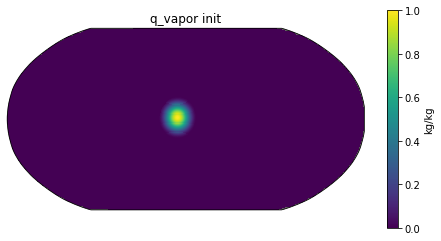

[output:0]

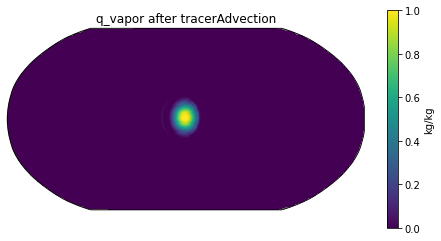

[output:0]

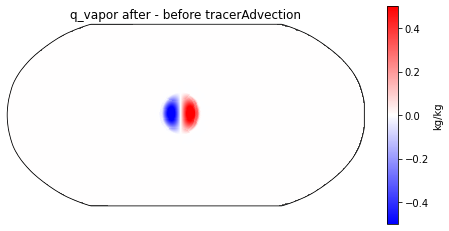

In [420]:

if mpi_rank == 0:
    variables = {'lon': lon_global.data, 'lat': lat_global.data, 'q_start': qvapor_start.data[:, :, :, 0], 'q_end': qvapor_end.data[:, :, :, 0]}
    func.plot_projection_field(variables['lon'], variables['lat'], variables['q_start'], vmin=-0, vmax=1, cmap='viridis', title='q_vapor init', units=units['qvapor'])
    func.plot_projection_field(variables['lon'], variables['lat'], variables['q_end'], vmin=-0, vmax=1, cmap='viridis', title='q_vapor after tracerAdvection', units=units['qvapor'])
    func.plot_projection_field(variables['lon'], variables['lat'], (variables['q_end'] - variables['q_start']), vmin=-.5, vmax=.5, cmap='bwr', title='q_vapor after - before tracerAdvection', units='kg/kg')